In [1]:
!GIT_SSL_NO_VERIFY=1  pip install git+https://github.com/TimeSynth/TimeSynth.git

  Cloning https://github.com/TimeSynth/TimeSynth.git to /tmp/pip-req-build-7ujkcemy
  Running command git clone --filter=blob:none --quiet https://github.com/TimeSynth/TimeSynth.git /tmp/pip-req-build-7ujkcemy
  Resolved https://github.com/TimeSynth/TimeSynth.git to commit e50cdb9015d415adf46a4eae161a087c5c378564
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 3.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 3.4 MB/s eta 0:00:00
  DEPRECATION: Building 'timesynth' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-bu

In [25]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import timesynth as ts
from timesynth.noise.gaussian_noise import GaussianNoise
from timesynth.signals import AutoRegressive, PseudoPeriodic, Sinusoidal
from timesynth import TimeSampler, TimeSeries
from typing import Any, Dict, List

In [3]:
def generate_timeseries(n_samples=300, frequency=0.25, amplitude=1.0, noise=GaussianNoise(std=0.3), cycles=1, signal=None):
    if not signal:
        signal = Sinusoidal(frequency=frequency)
        signal.amplitude = amplitude

    if cycles > 1:
        stop_time = cycles / frequency
    else:
        stop_time = n_samples / frequency
        
    time_sampler = TimeSampler(stop_time=stop_time)
    regular_time_samples = time_sampler.sample_regular_time(num_points=n_samples)

    timeseries = TimeSeries(signal_generator=signal, noise_generator=noise)
    samples, signals, errors = timeseries.sample(regular_time_samples)

    return regular_time_samples, samples, signals, errors

In [4]:
class CustomAutoRegressive(AutoRegressive):
    def sample_next(self, time, samples, errors):
        ar_value = sum(self.previous_value[i] * self.ar_param[i] for i in range(len(self.ar_param)))
        noise = float(np.random.normal(loc=0.0, scale=self.sigma))  # ensure scalar
        ar_value += noise
        self.previous_value = self.previous_value[1:] + [ar_value]
        
        return ar_value

In [5]:
def plot_timeseries(times_series: List[Dict[str, Any]], plot_errors=False, title='Generated Time Series Data') -> None:
    plt.figure(figsize=(10, 6))

    for i, series in enumerate(times_series):
        label = series['label'] if 'label' in series else 'Signal {i+1}'
        samples = np.array(series['samples'], dtype=float)
        signals = np.array(series['signals'], dtype=float)
        errors = series.get('errors', None)

        if isinstance(errors, str):
            print(f"Skipping 'errors' for Signal {i+1} because it is a string: {errors}")
            errors = None
        elif errors is not None:
            try:
                errors = np.array(errors, dtype=float)
            except Exception as e:
                print(f"Could not convert 'errors' for Signal {i+1}: {e}")
                errors = None

        plt.plot(samples, signals, label=label)
        
        if plot_errors and errors is not None:
            plt.plot(samples, signals + errors, label=f'Signal {i+1} with Noise', linestyle='--')

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
noise = GaussianNoise(std=0.1)
regular_time_samples_1, samples_1, signals_1, errors_1 = generate_timeseries(n_samples=100, amplitude=1.5, frequency=2, noise=noise, cycles=4)
regular_time_samples_2, samples_2, signals_2, errors_2 = generate_timeseries(n_samples=100, amplitude=1, frequency=2, noise=noise, cycles=4)
regular_time_samples_3, samples_3, signals_3, errors_3 = generate_timeseries(n_samples=100, amplitude=1.5, frequency=1, noise=noise)
regular_time_samples_4, samples_4, signals_4, errors_4 = generate_timeseries(n_samples=100, amplitude=1, frequency=1, noise=noise)

In [7]:
times_series_1 = {"samples" : regular_time_samples_1, "signals": signals_1, "errors": errors_1}
times_series_2 = {"samples" : regular_time_samples_2, "signals": signals_2, "errors": errors_2}
times_series = [times_series_1, times_series_2]

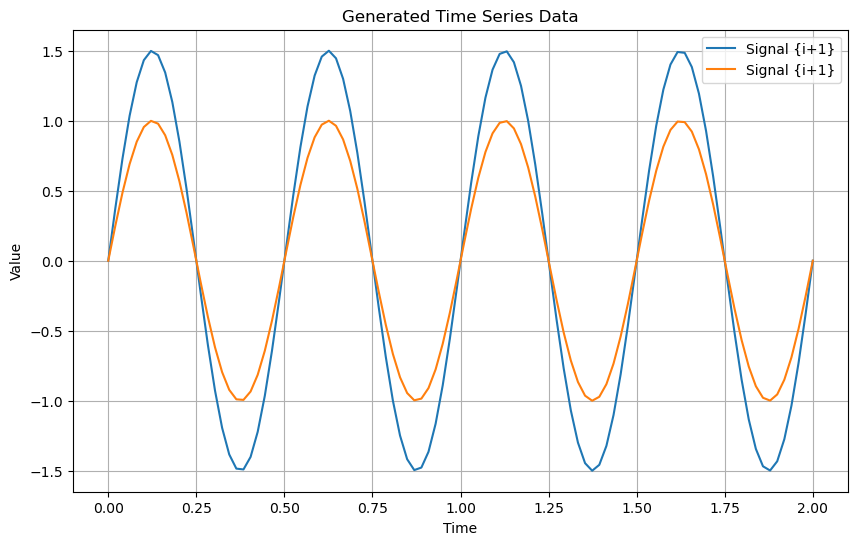

In [8]:
plot_timeseries(times_series)

In [12]:
times_series_3 = {"samples" : regular_time_samples_3, "signals": signals_3, "errors": errors_3}
times_series_4 = {"samples" : regular_time_samples_4, "signals": signals_4, "errors": errors_4}
times_series = [times_series_3, times_series_4]

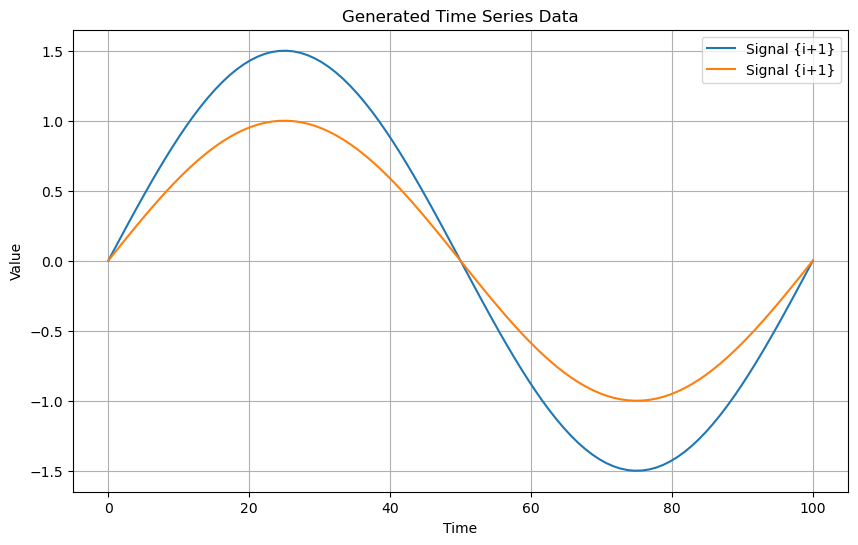

In [13]:
plot_timeseries(times_series)

In [14]:
signal = PseudoPeriodic(amplitude=1, frequency=0.25)
noise = GaussianNoise(std=0.3)

In [15]:
regular_time_samples, pseudo_periodic_samples, _, _ = \
    generate_timeseries(n_samples=100, 
    amplitude=1, 
    frequency=2, 
    noise=noise, 
    signal=signal)

In [16]:
signal = CustomAutoRegressive(ar_param=[0.90, -0.2])

In [17]:
regular_time_samples, ar_samples, _, _ = \
    generate_timeseries(n_samples=100, 
    amplitude=1, 
    frequency=2,                     
    signal=signal)

In [18]:
pad_length = len(pseudo_periodic_samples) - len(ar_samples)
ar_samples_padded = np.pad(ar_samples, (0, pad_length), mode='constant')
pseudo_periodic_with_ar_signal = pseudo_periodic_samples * 2 + ar_samples_padded

In [19]:
pseudo_periodic_with_ar_time_series = [{"samples" : regular_time_samples, 
                                        "signals": pseudo_periodic_with_ar_signal,
                                        "label": "AR Pseudoperiodic"},
                                       {"samples": regular_time_samples, 
                                        "signals": pseudo_periodic_samples,
                                        "label": "Pseudoperiodic"}]

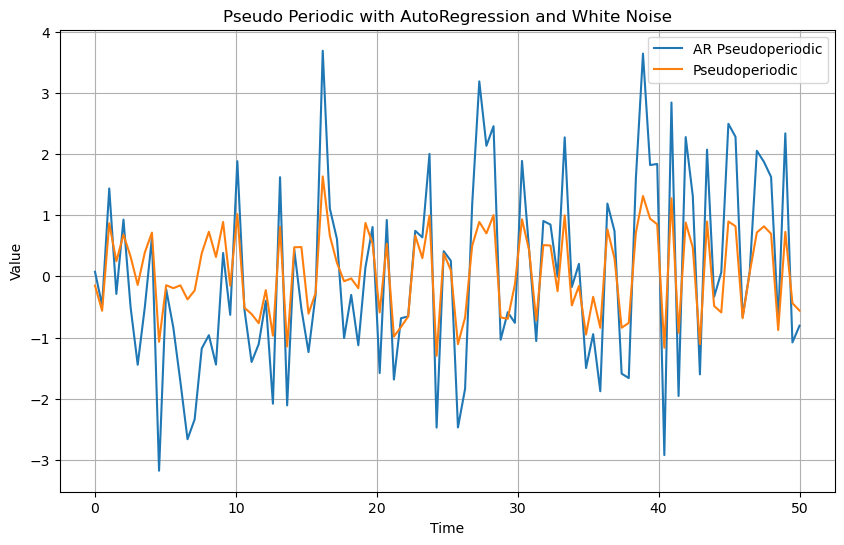

In [20]:
plot_timeseries(pseudo_periodic_with_ar_time_series, title="Pseudo Periodic with AutoRegression and White Noise")

### White Noise

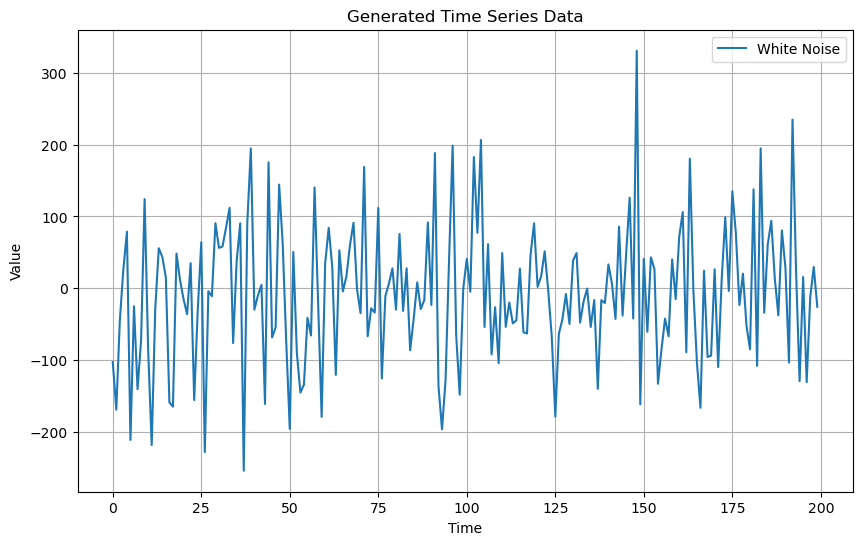

In [23]:
samples = np.arange(200)
signals = np.random.randn(200) * 100

times_series = [{"samples" : samples, "signals": signals, "label": "White Noise"}]
plot_timeseries(times_series)

### Red Noise

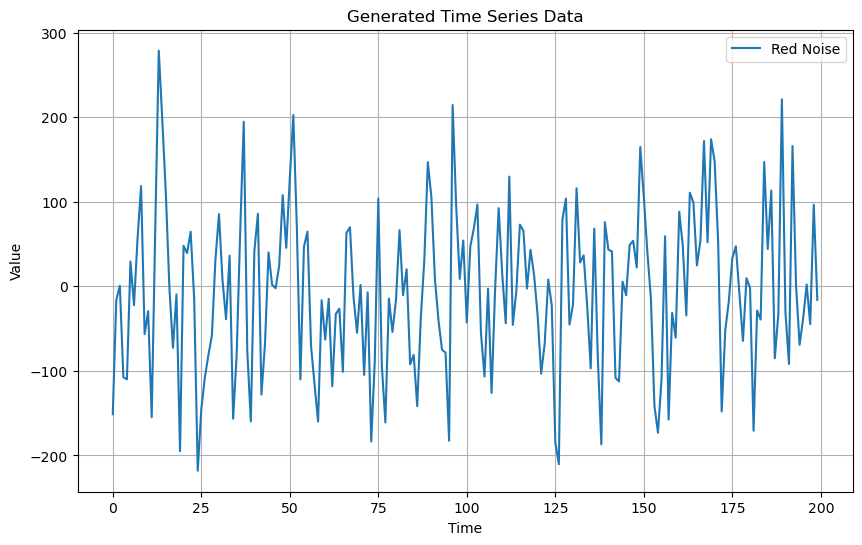

In [32]:
r = 0.4
samples = np.arange(200)
white_noise = np.random.randn(200) * 100
signals = np.zeros(200) # Create red noise by introducing correlation between subsequent values in the white noise

for i, v in enumerate(white_noise):
    if i ==0:
        signals[i] = v
    else:
        signals[i] = r * signals[i-1] + np.sqrt((1 - np.power(r, 2))) * v

times_series = [{"samples" : samples, "signals": signals, "label": "Red Noise"}]
plot_timeseries(times_series)

In [36]:
seasonal_samples

array([-0.34695103, -0.13058762,  0.49003512,  0.21658676,  0.20400788,
        0.57033707,  0.67388157,  1.18070259,  0.57732863,  0.54630861,
        0.92829287,  1.29333737,  0.80965679,  0.60589703,  0.75471523,
        0.87070926,  0.36008453,  0.90586851,  0.67194717,  0.25951264,
        0.17262565, -0.39929296, -0.48152565, -0.87347508, -0.85936251,
       -0.58805861, -1.02983414, -1.10061705, -0.99859368, -1.15426067,
       -0.81289665, -0.71219613, -1.14570638, -0.92783727, -0.63466345,
       -0.15746183, -0.14000705, -0.26497057,  0.49826299,  0.2030668 ])

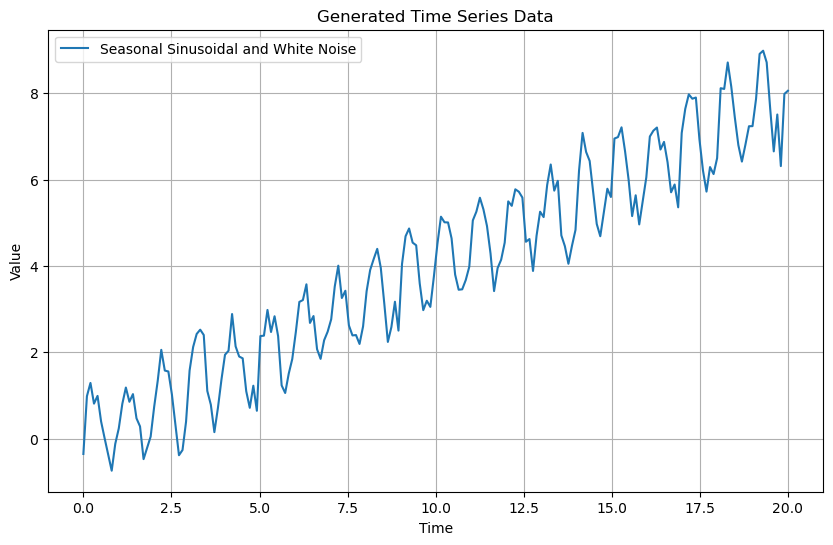

In [46]:
noise = GaussianNoise(std=0.3)
seasonal_time_samples, \
seasonal_samples, \
seasonal_signals, \
errors_4 = generate_timeseries(n_samples=200, 
                               amplitude=1, 
                               frequency=1, 
                               noise=noise,
                              cycles=20)
trend = seasonal_time_samples*0.4
trends_plus_signals = seasonal_samples + trend
seasonal_times_series = [{"samples" : seasonal_time_samples, "signals": trends_plus_signals, "label": "Seasonal Sinusoidal and White Noise"}]
plot_timeseries(seasonal_times_series)